In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') #忽视警告

plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

import jieba
import jieba.analyse
from wordcloud import WordCloud


# 读取数据

In [2]:
df = pd.read_csv("herstory_hot_comments.csv")

# 分词

In [3]:
#加载外部分词字典
jieba.load_userdict("userdict.txt")

# 使用jieba进行中文分词
def chinese_segmentation(text):
    words = jieba.cut(text, cut_all=False, HMM=True)
    return " ".join(words)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\ADMINI~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.354 seconds.
Prefix dict has been built successfully.


In [4]:
# 对DataFrame的'comment_text'列应用中文分词
df['comment_text_segmented'] = df['comment_text'].apply(chinese_segmentation)

In [5]:
df['comment_text_segmented']

0      最 爱 小孩子 猜 声音 那段 ， 算得 上 看过 的 电影 里 相当 浪漫 的 叙事 了 ...
1                      给 母亲 的 家务活 拟音 配音 的 真的 是 年度 名 场面 。
2                       我 正直 勇敢 有 阅读 量 ， 我 有 什么 好 可怜 的 ！
3      女儿 听 声音 的 那场 戏 说明 了 ， 女性 的 声音 ， 也 是 世界 的 声音 。 ...
4             茉莉 才 是 看 完 了 王铁梅 所有 的 报道 。 去 创造 新 的 游戏规则 ！
                             ...                        
395               如果 一个 男 的 反复强调 自己 是 女权主义 好像 也 挺 可怕 的 😂
396    今年 真的 好 幸福 ， 前有 《 出走 的 决心 》 ， 现在 又 有 《 好东西 》 ，...
397    已经 没有 正常 人类 了 ， 就 前夫哥 和 架子鼓男 第一次 见面 能 有 那 一段 对...
398    比 爱情神话 成熟 流畅 很多 ， 干 家务活 配音 那段 真的 很妙 ， 没有 刻意 去 ...
399    笑 中 带泪 。 最 喜欢 的 一段 是 配音 ， 沙漠 、 雷暴 、 阵雨 ， 大自然 的...
Name: comment_text_segmented, Length: 400, dtype: object

# 同义词替换

In [6]:
# 加载同义词文件
synonym_file_path = 'synonym.txt'
synonym_dict = {}

# 读取同义词文件，创建同义词典，将同义词映射到主词
with open(synonym_file_path, 'r', encoding='utf-8') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) > 1:
            main_word = parts[0]
            synonyms = parts[1:]
            for synonym in synonyms:
                synonym_dict[synonym] = main_word

# 替换同义词的函数（针对已分词的情况）
def replace_synonyms(words):
    # 使用同义词典替换同义词为主词
    replaced_words = [synonym_dict.get(word, word) for word in words]

    # 将分词结果拼接成字符串
    return " ".join(replaced_words)

# 对 'comment_text_segmented' 列应用替换同义词的函数
df['comment_text_segmented'] = df['comment_text_segmented'].apply(lambda x: replace_synonyms(x.split()))

# 显示替换同义词后的 DataFrame
print(df['comment_text_segmented'])


0      最 爱 小孩子 猜 声音 那段 ， 算得 上 看过 的 电影 里 相当 浪漫 的 叙事 了 ...
1                      给 母亲 的 家务活 拟音 配音 的 真的 是 年度 名 场面 。
2                       我 正直 勇敢 有 阅读 量 ， 我 有 什么 好 可怜 的 ！
3      女儿 听 声音 的 那场 戏 说明 了 ， 女性 的 声音 ， 也 是 世界 的 声音 。 ...
4            王茉莉 才 是 看 完 了 王铁梅 所有 的 报道 。 去 创造 新 的 游戏规则 ！
                             ...                        
395              如果 一个 男性 的 反复强调 自己 是 女性主义 好像 也 挺 可怕 的 😂
396    今年 真的 好 幸福 ， 前有 《 出走 的 决心 》 ， 现在 又 有 《 好东西 》 ，...
397    已经 没有 正常 人类 了 ， 就 前夫 和 小马 第一次 见面 能 有 那 一段 对话 我...
398    比 爱情神话 成熟 流畅 很多 ， 干 家务活 配音 那段 真的 很妙 ， 没有 刻意 去 ...
399    笑 中 带泪 。 最 喜欢 的 一段 是 配音 ， 沙漠 、 雷暴 、 阵雨 ， 大自然 的...
Name: comment_text_segmented, Length: 400, dtype: object


# 词频分析

- 没有过滤停用词，纯词频方法

In [7]:
# 将分好词的文本拆分成词语列表
df['comment_text_segmented_list'] = df['comment_text_segmented'].str.split()

# 使用explode将词语列表展开为单独的行
df_tokens = df.explode('comment_text_segmented_list')

# 重新设置索引
df_tokens = df_tokens.reset_index(drop=True)

# 打印结果
df_tokens.comment_text_segmented_list

0          最
1          爱
2        小孩子
3          猜
4         声音
        ... 
30792     发出
30793      你
30794      的
30795     声音
30796      。
Name: comment_text_segmented_list, Length: 30797, dtype: object

In [8]:
# 词频统计
df_tokens["comment_text_segmented_list"].value_counts()

comment_text_segmented_list
，       2241
的       2046
。        893
是        493
了        473
        ... 
调皮         1
犹如         1
热泪盈眶       1
得令         1
发出         1
Name: count, Length: 5828, dtype: int64

In [9]:
#导出数据
df_tokens["comment_text_segmented_list"].value_counts().to_excel("freq.xlsx")

# 过滤停用词，并使用tf-idf算法提取关键词

**tf-idf算法的基本思想**：词语的重要性与其出现的频率有关，总体而言，词频越高重要性越大；但是，但词频太高的时候，反而说明词语的重要性没有那么高（如：如果所有的句子都提到“电影”这个词，那么“电影”这个词的重要性就没有那么高）。

In [ ]:
import jieba.analyse
jieba.analyse.set_stop_words('stopwords.txt')
#合并一起
text = ''
for i in range(len(df['comment_text_segmented'])):
    text += df['comment_text_segmented'][i]+'\n'
j_r = jieba.analyse.extract_tags(text,topK=20,withWeight=True)
df1 = pd.DataFrame()
df1['word']= [word[0] for word in j_r]  ;df1['freq']=[word[1] for word in j_r]
df1

,word,freq
0,王铁梅,0.171540
1,女性,0.156550
2,电影,0.147065
3,邵艺辉,0.146589
4,女性主义,0.112281
5,王茉莉,0.098765
6,男性,0.097524
7,好东西,0.069656
8,爱情神话,0.059259
9,小叶,0.044717


# 关键词语义网络分析

In [11]:
from tkinter import _flatten

# 步骤1：从外部文件读取停用词
with open("stopwords.txt", "r", encoding="utf-8") as file:
    stopwords = file.read().splitlines()

# 步骤2：对评论进行分词并过滤停用词
comment_text_segmented_list = list(map(lambda x: ''.join(x), df['comment_text_segmented'].tolist()))
content_str = ' '.join(comment_text_segmented_list).split()

# 过滤停用词
filtered_content = [word for word in content_str if word not in stopwords]

# 过滤停用词后计算词频
word_freq = pd.Series(_flatten(filtered_content)).value_counts()

# 显示前20个词
print(word_freq[:20])


女性      269
电影      254
王铁梅     165
男性      155
邵艺辉     141
女性主义    108
王茉莉      95
声音       93
喜欢       88
好东西      67
生活       67
表达       62
爱情神话     57
角色       56
小叶       56
台词       46
世界       45
故事       42
性别       35
观众       35
Name: count, dtype: int64


In [12]:
keywords = word_freq[:20].index
keywords

Index(['女性', '电影', '王铁梅', '男性', '邵艺辉', '女性主义', '王茉莉', '声音', '喜欢', '好东西', '生活',
       '表达', '爱情神话', '角色', '小叶', '台词', '世界', '故事', '性别', '观众'],
      dtype='object')

In [13]:
matrix = np.zeros((len(keywords)+1)*(len(keywords)+1)).reshape(len(keywords)+1, len(keywords)+1).astype(str)
matrix[0][0] = np.NaN
matrix[1:, 0] = matrix[0, 1:] = keywords
matrix

array([['nan', '女性', '电影', '王铁梅', '男性', '邵艺辉', '女性主义', '王茉莉', '声音', '喜欢',
        '好东西', '生活', '表达', '爱情神话', '角色', '小叶', '台词', '世界', '故事', '性别',
        '观众'],
       ['女性', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0'],
       ['电影', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0'],
       ['王铁梅', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0'],
       ['男性', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0'],
       ['邵艺辉', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0',
        '0.0'

In [14]:
# 将评论按空格分割为单词列表
cont_list = [cont.split() for cont in comment_text_segmented_list]

# 遍历前20个词频最高的单词
for i, w1 in enumerate(word_freq[:20].index):
    for j, w2 in enumerate(word_freq[:20].index):
        count = 0

        # 遍历每条评论的单词列表
        for cont in cont_list:
            # 检查当前两个单词是否同时出现在同一条评论中
            if w1 in cont and w2 in cont:
                # 检查这两个单词在评论中的位置差距是否为0或1
                if abs(cont.index(w1) - cont.index(w2)) == 0 or abs(cont.index(w1) - cont.index(w2)) == 1:
                    count += 1

        # 将计数结果填充到矩阵的相应位置
        matrix[i + 1][j + 1] = count


In [15]:
matrix

array([['nan', '女性', '电影', '王铁梅', '男性', '邵艺辉', '女性主义', '王茉莉', '声音', '喜欢',
        '好东西', '生活', '表达', '爱情神话', '角色', '小叶', '台词', '世界', '故事', '性别',
        '观众'],
       ['女性', '148', '3', '0', '1', '8', '0', '0', '0', '0', '0', '0',
        '0', '0', '3', '0', '0', '2', '1', '0', '3'],
       ['电影', '3', '151', '0', '0', '2', '1', '0', '0', '0', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['王铁梅', '0', '0', '104', '0', '0', '0', '0', '0', '0', '0', '0',
        '0', '0', '1', '1', '0', '0', '0', '0', '0'],
       ['男性', '1', '0', '0', '84', '4', '1', '0', '0', '0', '0', '0',
        '1', '0', '3', '0', '0', '0', '0', '0', '0'],
       ['邵艺辉', '8', '2', '0', '4', '100', '0', '0', '0', '1', '0', '0',
        '0', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['女性主义', '0', '1', '0', '1', '0', '70', '0', '0', '0', '0', '0',
        '1', '0', '0', '0', '0', '0', '0', '0', '0'],
       ['王茉莉', '0', '0', '0', '0', '0', '0', '74', '0', '5', '0', '0',
        '0', '0',

In [16]:
kwdata = pd.DataFrame(data=matrix)
kwdata.to_csv('关键词共现矩阵.csv', index=False, header=None, encoding='utf-8-sig')

In [17]:
kwdata= pd.read_csv('关键词共现矩阵.csv')
kwdata.index = kwdata.iloc[:, 0].tolist()
kwdata_ = kwdata.iloc[:20, 1:21]
kwdata_.astype(int)

,女性,电影,王铁梅,男性,邵艺辉,女性主义,王茉莉,声音,喜欢,好东西,生活,表达,爱情神话,角色,小叶,台词,世界,故事,性别,观众
女性,148,3,0,1,8,0,0,0,0,0,0,0,0,3,0,0,2,1,0,3
电影,3,151,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
王铁梅,0,0,104,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
男性,1,0,0,84,4,1,0,0,0,0,0,1,0,3,0,0,0,0,0,0
邵艺辉,8,2,0,4,100,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
女性主义,0,1,0,1,0,70,0,0,0,0,0,1,0,0,0,0,0,0,0,0
王茉莉,0,0,0,0,0,0,74,0,5,0,0,0,0,0,0,0,0,0,0,0
声音,0,0,0,0,0,0,0,75,1,0,0,0,0,0,0,0,0,0,0,0
喜欢,0,0,0,0,1,0,5,1,67,0,0,0,0,0,0,0,0,0,0,0
好东西,0,0,0,0,0,0,0,0,0,54,0,0,0,0,0,0,0,0,0,0


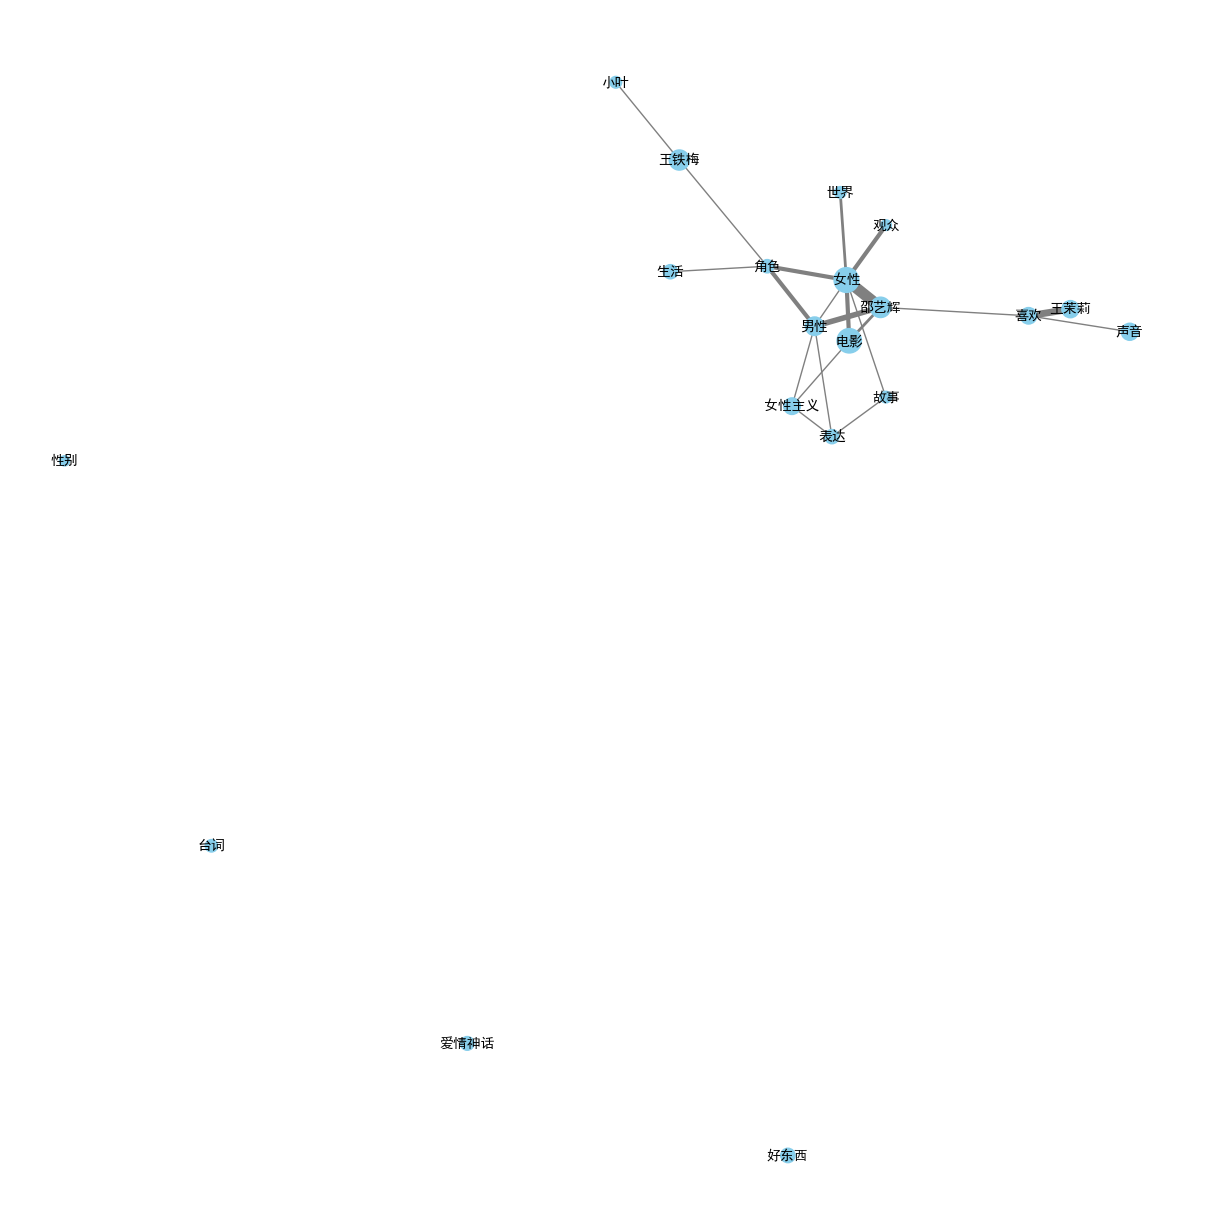

In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 读取关键词共现矩阵数据
co_occurrence_matrix = pd.read_csv("关键词共现矩阵.csv", index_col=0)

# 创建关键词共现网络图
graph = nx.from_pandas_adjacency(co_occurrence_matrix)

# 计算每个节点的关联强度，作为节点大小
node_weights = dict(graph.degree(weight='weight'))

# 计算每条边的关联强度，这里可以使用边的权重作为关联强度
edge_weights = nx.get_edge_attributes(graph, 'weight')

# 设置布局
pos = nx.spring_layout(graph)

# 绘制网络图，根据关联强度画出线条粗细，排除对角线上的值
plt.figure(figsize=(12, 12))

# 根据节点权重调整节点大小
node_size = [node_weights[node] * 1 for node in graph.nodes()]

nx.draw(
    graph,
    pos,
    with_labels=True,
    node_color='skyblue',
    font_size=10,
    node_size=node_size,
    edgelist=[edge for edge in edge_weights if edge[0] != edge[1]],  # 排除对角线上的值
    width=[edge_weights[edge] for edge in edge_weights if edge[0] != edge[1]],
    edge_color='gray',
)

# 显示图像
plt.show()


# 影视剧人物语义网络分析

In [32]:
character_list = ["王铁梅", "王茉莉", "小叶", "前夫", "小马", "胡医生"]

In [33]:
matrix = np.zeros((len(character_list)+1)*(len(character_list)+1)).reshape(len(character_list)+1, len(character_list)+1).astype(str)
matrix[0][0] = np.NaN
matrix[1:, 0] = matrix[0, 1:] = character_list
matrix

array([['nan', '王铁梅', '王茉莉', '小叶', '前夫', '小马', '胡医生'],
       ['王铁梅', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
       ['王茉莉', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
       ['小叶', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
       ['前夫', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
       ['小马', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0'],
       ['胡医生', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']], dtype='<U32')

In [21]:
# 将评论按空格分割为单词列表
cont_list = [cont.split() for cont in comment_text_segmented_list]

# 遍历影视角色列表
for i, w1 in enumerate(character_list):
    for j, w2 in enumerate(character_list):
        count = 0

        # 遍历每条评论的影视角色列表
        for cont in cont_list:
            # 检查当前两个影视角色是否同时出现在同一条评论中
            if w1 in cont and w2 in cont:
                count += 1

        # 将计数结果填充到矩阵的相应位置
        matrix[i + 1][j + 1] = count


In [22]:
matrix

array([['nan', '王铁梅', '王茉莉', '小叶', '前夫', '小马', '胡医生'],
       ['王铁梅', '104', '43', '31', '14', '15', '2'],
       ['王茉莉', '43', '74', '21', '6', '12', '2'],
       ['小叶', '31', '21', '35', '10', '9', '2'],
       ['前夫', '14', '6', '10', '27', '9', '2'],
       ['小马', '15', '12', '9', '9', '30', '2'],
       ['胡医生', '2', '2', '2', '2', '2', '4']], dtype='<U32')

In [23]:
char_data = pd.DataFrame(data=matrix)
char_data.to_csv('人物共现矩阵.csv', index=False, header=None, encoding='utf-8-sig')

In [24]:
char_data= pd.read_csv('人物共现矩阵.csv')
char_data.index = char_data.iloc[:, 0].tolist()
char_data_ = char_data.iloc[:20, 1:21]
char_data_.astype(int)

,王铁梅,王茉莉,小叶,前夫,小马,胡医生
王铁梅,104,43,31,14,15,2
王茉莉,43,74,21,6,12,2
小叶,31,21,35,10,9,2
前夫,14,6,10,27,9,2
小马,15,12,9,9,30,2
胡医生,2,2,2,2,2,4


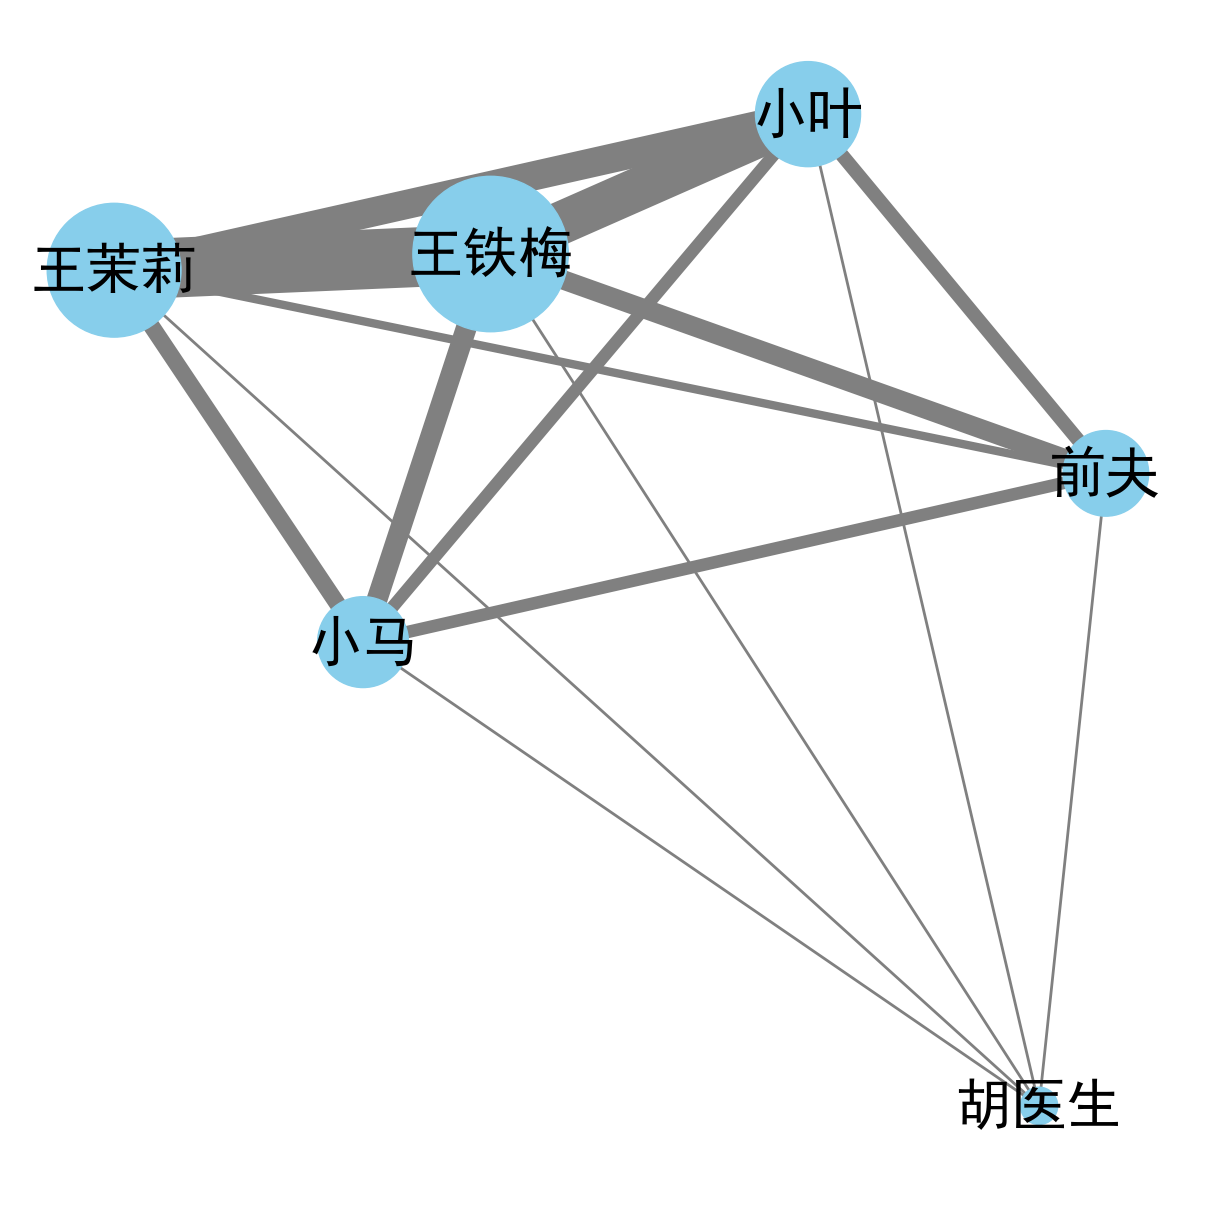

In [25]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 读取人物共现矩阵数据
co_occurrence_matrix = pd.read_csv("人物共现矩阵.csv", index_col=0)

# 创建人物共现网络图
graph = nx.from_pandas_adjacency(co_occurrence_matrix)

# 计算每个节点的关联强度，作为节点大小
node_weights = dict(graph.degree(weight='weight'))

# 计算每条边的关联强度，这里可以使用边的权重作为关联强度
edge_weights = nx.get_edge_attributes(graph, 'weight')

# 设置布局
pos = nx.spring_layout(graph)

# 绘制网络图，根据关联强度画出线条粗细，忽略对角线上的值
plt.figure(figsize=(12, 12))

# 根据节点权重调整其大小
node_size = [node_weights[node] * 40 for node in graph.nodes()]

nx.draw(
    graph,
    pos,
    with_labels=True,
    node_color='skyblue',
    font_size=40,
    node_size=node_size,
    edgelist=[edge for edge in edge_weights if edge[0] != edge[1]],  # 排除对角线上的值
    width=[edge_weights[edge] for edge in edge_weights if edge[0] != edge[1]],
    edge_color='gray',
)

# 显示图像
plt.show()


# 提取出分好词的字符串格式的文本

In [26]:
# 对所有'comment_text_segmented'文本进行拼接
all_comment_text_text = " ".join(df['comment_text_segmented'])

In [27]:
all_comment_text_text

'最 爱 小孩子 猜 声音 那段 ， 算得 上 看过 的 电影 里 相当 浪漫 的 叙事 了 。 很 温和 也 很 有 爱 。 给 母亲 的 家务活 拟音 配音 的 真的 是 年度 名 场面 。 我 正直 勇敢 有 阅读 量 ， 我 有 什么 好 可怜 的 ！ 女儿 听 声音 的 那场 戏 说明 了 ， 女性 的 声音 ， 也 是 世界 的 声音 。 我们 通常 没有 用 这种 方式 去 留意 过 、 听见 过 、 定义 过 这些 属于 女性 的 声音 。 王茉莉 才 是 看 完 了 王铁梅 所有 的 报道 。 去 创造 新 的 游戏规则 ！ 年度 最佳 ！ 评论 区有 打 一星 、 说 邵艺辉 吃 女性主义 红利 吃 上瘾 讨好 女性 观众 的 ， 就算 是 ， 怎么 就 不能 讨好 了 ， 是 我们 女性 观众 不配 被 讨好 吗 ？ 在 吹毛求疵 什么 呢 ？ 我 就 吃 这 一套 ！ 更何况 这部 作品 也 根本 谈不上 激进 ， 甚至 电影 里 对 男性 形象 还是 美化 的 ， 没有 表现 出 丝毫 对 男性 的 恶意 ， 非常 真实 、 细致 动人 ！ 那么 多 成百上千 讨好 男性 的 电影 怎么 之前 不说 ？ 在 男性 英雄主义 角色 玩转 乾坤 、 占领 话语权 的 时代 ， 难得 有 女性 邵艺辉 脱颖而出 ， 打造 了 一个 现实主义 但 女性 本位 的 世界 ， 完成度 极高 ， 剧作 功底 极好 ， 如此 优秀 的 作品 ， 不 应该 多多 鼓励 嘛 ？ ( 部分 男性 的 不要 去 我 主页 动态 底下 骂 我 了 ， 攻击 不到 我 的 ， 你们 这种 行为 让 这部 片子 的 含金量 又 增加 了 ) “ 你 看过 几本 上野千鹤子 啊 ？ ” ， 一 想到 这么 好玩 的 电影 热度 不大 我 就 急 的 团团转 小马 被 扒 衣服 的 那 一段 ， 全场 女生 大笑 ， 我们 什么 时候 在 中国 的 电影 里 看到 过 这样 的 场面 ， 共享 过 这样 的 笑声 ？ 当 影片 迎来 一个 非常 俗气 的 结尾 ， 闪耀 的 聚光灯 照 在 小孩儿 头顶 ， 如此 土气 的 设计 ， 却 让 我 觉得 是 最 棒 的 一幕 。 我们 何尝 拥有 过 这样 耀眼 的 结尾 ？ 我们 看 了 这么 多 的 电影 ， 看 了 那么

# 词云分析

- **默认模式**

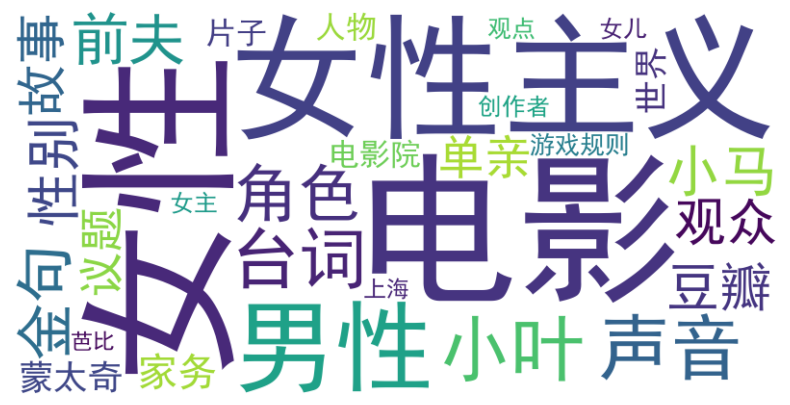

In [28]:
# 创建词云，并排除停用词
def generate_wordcloud(text):
    # 从外部文件读取停用词列表
    jieba.analyse.set_stop_words("stopwords.txt")
    
    # 使用 jieba.analyse.extract_tags 提取关键词
    keywords = jieba.analyse.extract_tags(text, topK=30, withWeight=True, allowPOS=('n', 'nr', 'ns'))#allowPOS=('n', 'nr', 'ns')：表示仅考虑名词（'n'）、人名（'nr'）、地名（'ns'）等词性的词语作为关键词。这是通过词性标注来筛选关键词的一种方式。

    # 构建关键词和权重的字典
    keywords_dict = {word: weight for word, weight in keywords}

    # 创建词云
    wordcloud = WordCloud(
        width=800, 
        height=400, 
        background_color='white', 
        max_words=30, 
        collocations=False, 
        font_path= r'C:\Windows\Fonts\simhei.ttf',  # 使用支持中文的字体（黑体）
    ).generate_from_frequencies(keywords_dict)
    
    # 显示词云图像
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# 生成并显示词云
generate_wordcloud(all_comment_text_text)

# 哪些作品被quote到?

In [29]:
import re
import pandas as pd

# 提取包含在《》中的字符串的函数
def extract_titles(text):
    # 使用正则表达式提取《》中的字符串
    matches = re.findall(r'《(.*?)》', text)
    return matches

# 创建一个空的 DataFrame
df_work = pd.DataFrame(columns=['work Title', 'Original Title'])

# 遍历 comment_segmented 列
for index, row in df.iterrows():
    # 从 comment_text 中提取标题
    titles = extract_titles(row['comment_text'])
    
    # 遍历提取的标题
    for title in titles:
        # 将信息添加到新的 DataFrame
        df_work = pd.concat([df_work, pd.DataFrame({'work Title': [title], 'Original Title': [row['comment_text']]})], ignore_index=True)

# 打印结果或进行其他操作
print(df_work)


    work Title                                     Original Title
0        明天会更好  这是一部充满了善意，还相信世界会更好的电影。尽管片中《明天会更好》的副歌几乎唱全，只差了那一...
1        她不想打拳  《她不想打拳》《男人还挺好玩的》《不雄竞了？》…多好的生活文学啊，多棒的表达啊，别再面面俱到...
2      男人还挺好玩的  《她不想打拳》《男人还挺好玩的》《不雄竞了？》…多好的生活文学啊，多棒的表达啊，别再面面俱到...
3        不雄竞了？  《她不想打拳》《男人还挺好玩的》《不雄竞了？》…多好的生活文学啊，多棒的表达啊，别再面面俱到...
4         爱情神话  手松一点可以五星。比《爱情神话》更普适也更辛辣。这哪是中国的《芭比》啊，这是中国的《弗兰西丝哈》。
..         ...                                                ...
104      明天会更好  灵动，锐利，举重若轻。邵艺辉第二部作品，不论是情节的编织还是视听语言的运用都上了一个新台阶。...
105      出走的决心  今年真的好幸福，前有《出走的决心》，现在又有《好东西》，谁说我们女观众多年的发声没意义呢？这...
106        好东西  今年真的好幸福，前有《出走的决心》，现在又有《好东西》，谁说我们女观众多年的发声没意义呢？这...
107       爱情神话  今年真的好幸福，前有《出走的决心》，现在又有《好东西》，谁说我们女观众多年的发声没意义呢？这...
108        好东西  今年真的好幸福，前有《出走的决心》，现在又有《好东西》，谁说我们女观众多年的发声没意义呢？这...

[109 rows x 2 columns]


In [30]:
df_work.to_excel("df_work.xlsx")

In [31]:
# 使用 drop_duplicates 方法去除同一 Original Title 下的重复 work Title
df_unique_titles = df_work[['work Title', 'Original Title']].drop_duplicates()

# 统计 work Title 的频率
title_frequency = df_unique_titles['work Title'].value_counts()

# 打印结果或进行其他操作
title_frequency.head(20)

work Title
爱情神话         35
好东西          18
芭比            8
明天会更好         7
出走的决心         3
不雄竞了？         1
年会不能停         1
分手的决心         1
好東西           1
愛情神話          1
如何抑制女性写作      1
看不见的女人        1
游戏规则          1
某人某地          1
哈利波特与混血王子     1
女人世界          1
爱很美味          1
爱情呼叫转移        1
父权制与资本主义      1
痛             1
Name: count, dtype: int64